# Procedimiento de calibracion de la fase del modulador con una lente focalizando
Paper:


## Cargar Módulos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_masks_XY import Scalar_mask_XY

number of processors: 4
total memory        : 6.0 Gb
available memory    : 47 %
max frequency       : 2794 GHz


In [3]:
from py_lab.camera import Camera
from py_lab.motor_linear import Motor
from py_lab.slm import SLM
from py_lab.utils import List_COM_Ports
import time

In [4]:
# Camara
ms=1.
seconds=1000*ms

# Motores
s = 1

In [5]:
%matplotlib qt
%matplotlib inline

from matplotlib import rcParams

rcParams['figure.dpi']=300
plt.rcParams['image.cmap']='gray'

## Cargar dispositivos
### Mover Motor a una cierta posición


In [7]:
motor = Motor(name='SMC100')
motor.Open(port='COM3')
motor.Test_Connection()
#El Home es una función inicial para despazar el motor a un punto concreto fijo, el 0 de su sistema. 
motor.Home()

Connecting to SMC100 on COM3
Found stage ILS250PP_PN:B0921669954252_UD:091029
Stage SMC100 ready


In [8]:
z_inicial=110.1989

In [9]:
#Ahora, se mueve el motor para obtener el 0 de la imagen: 
#Para mover el motor, fijamos una velocidad y una posición absoluta, entre -125 Y 125 ("pos"). 
motor.Set_Velocity(vel=15, units='mm/s')
motor.Move_Absolute(pos=z_inicial,units='mm', verbose=True, move_time=None)

110.19888

### Cargamos la cámara

In [10]:
# Cámara
cam = Camera(name="ImagingSource") 
devices = cam.List_Devices(verbose=True)
cam.Open()
cam.Set_Property("Resolution", "Y800 (1024x768)")
#cam.Set_Property("Resolution", 'Y800 (2592x1944)')

# Framerate
cam.Set_Property("FrameRate", 5)
# Otros parametros
cam.Set_Property("Gain", 0, is_switcher=True)
cam.Set_Property("Gain", 2)
#Aquí podemos variar el tiempo de exposición de la cámara. 
value=int(np.log2(1/2000.))
print(value)
cam.Set_Property("Exposure", value)
cam.Start_Live() 


0 : b'DMx 72BUC02 14210296'



-10



### Cargar modulador

In [11]:
slm = SLM(name="HoloEye2500", M=0.795)

## Poner modulador en fase

In [12]:
motor.Move_Absolute(pos=z_inicial,units='mm', verbose=True, move_time=None)

110.19888

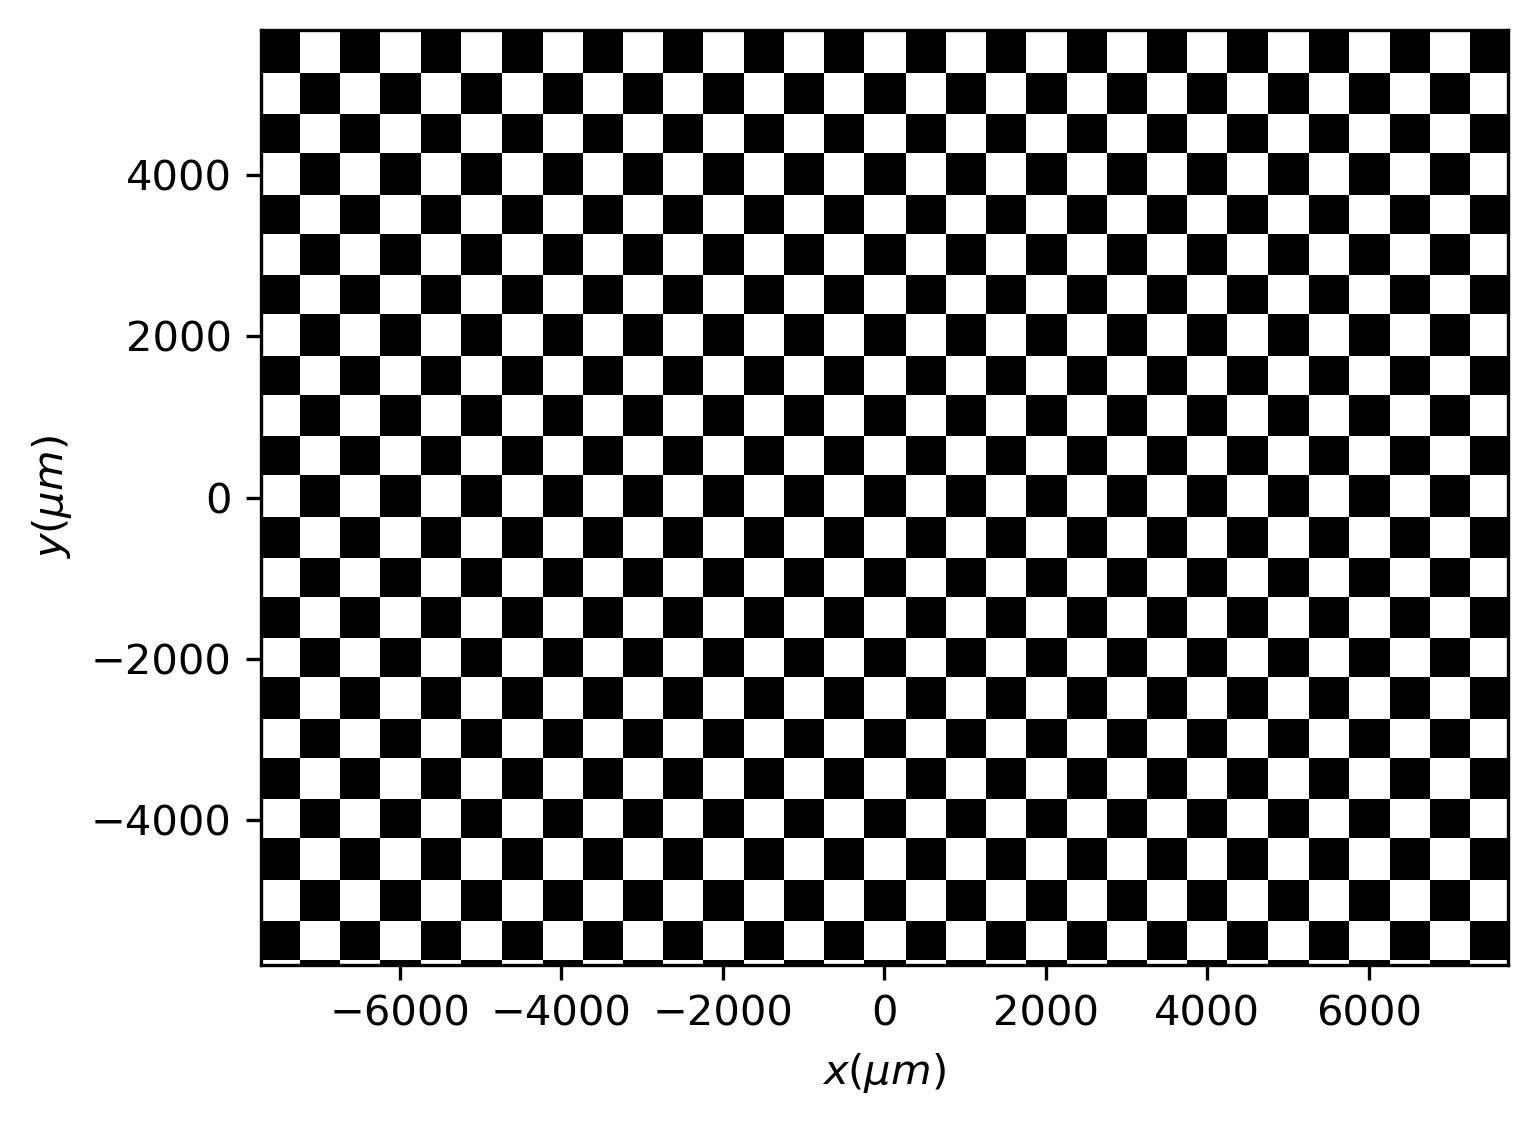

In [14]:
mask = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=slm.wavelength)
mask.grating_2D_chess(period=1000.0 * um, amin=0, amax=1., phase=0, r0=[0,0], fill_factor=0.5, angle=0.0 * degrees)
mask.draw()
slm.Send_Image(mask, norm=1, kind='intensity')

## Medir en el foco

In [15]:
focal=125

In [16]:
motor.Move_Absolute(pos=z_inicial-focal,units='mm', verbose=True, move_time=None)

-14.80108

In [18]:
background = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=slm.wavelength)
background.u=np.zeros_like(background.u)
enviado=slm.Send_Image(background, kind='amplitude',return_array=True)
time.sleep(0.3)
image_background = cam.Get_Image()
np.savez('background.npz', image=image_background)  

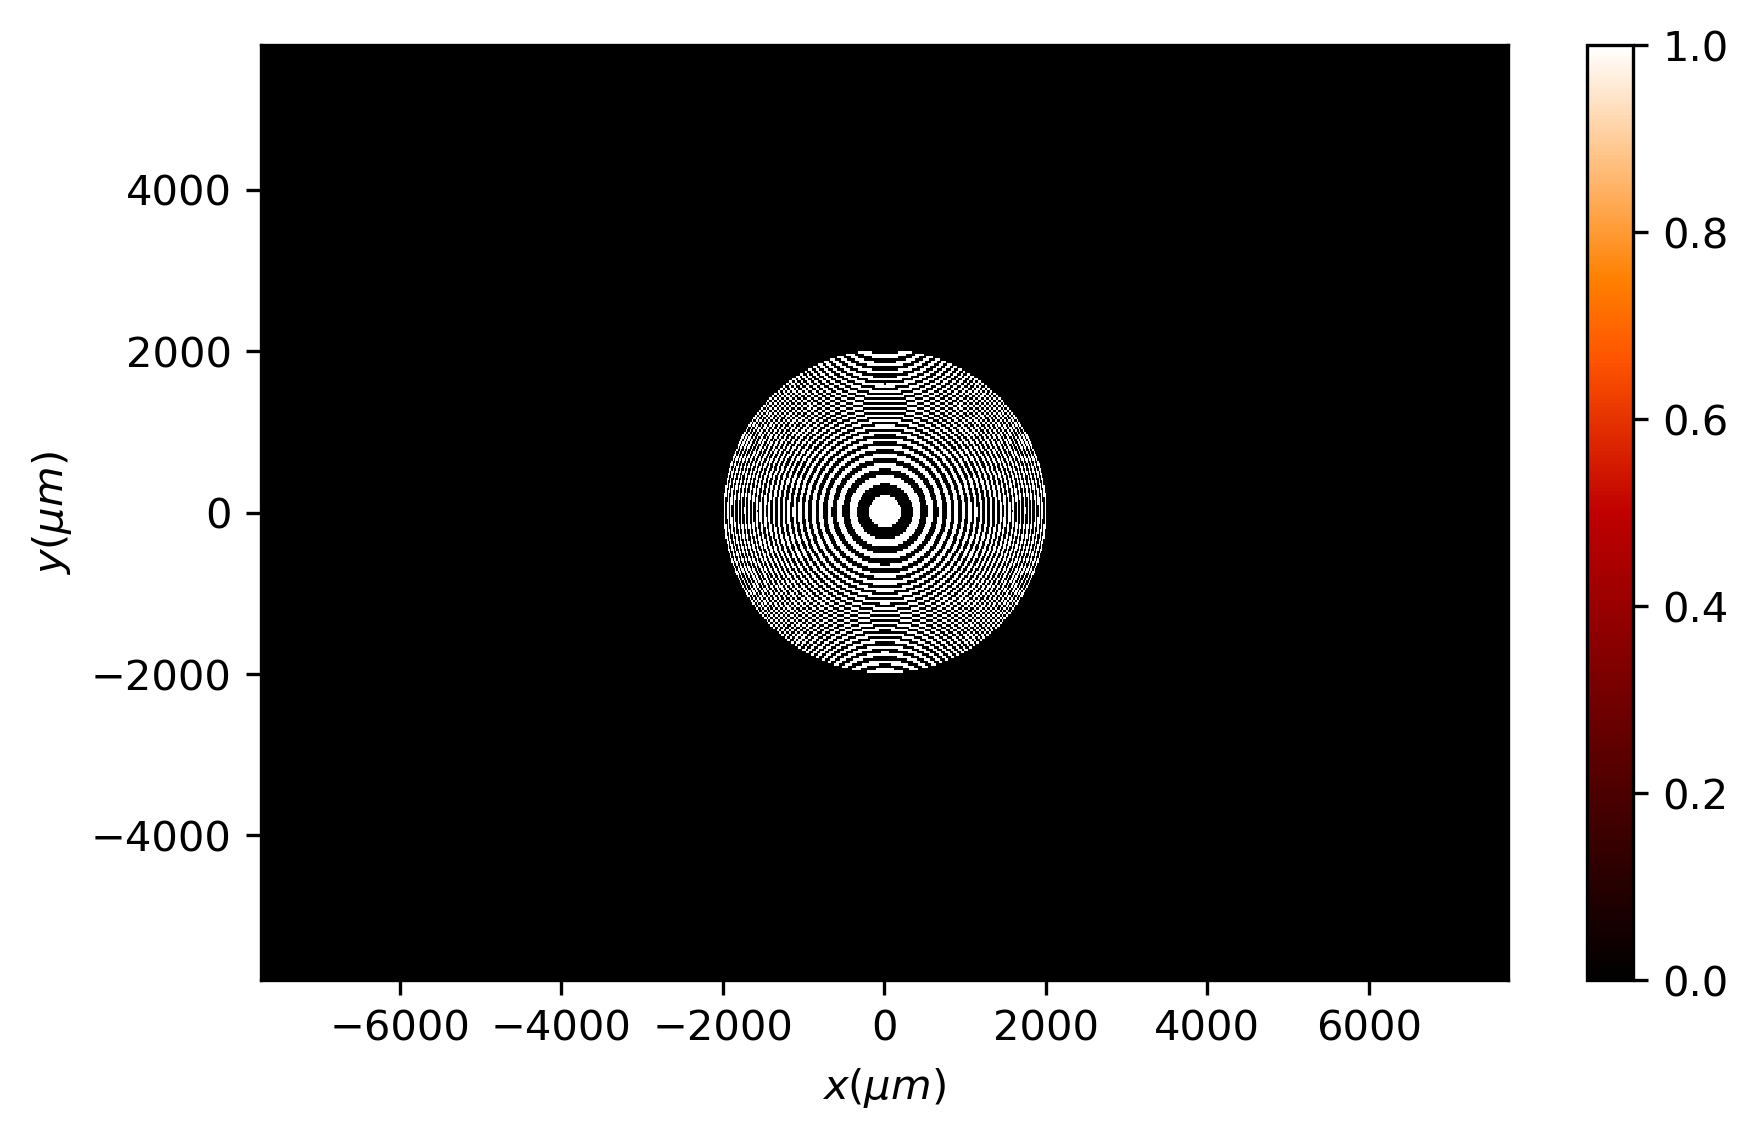

In [21]:
mask = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=slm.wavelength)
mask.fresnel_lens(r0=(0,0), radius=2*mm, focal=focal*1000, levels=(1, 0), kind='intensity')
#mask.gray_scale(num_levels=256, levelMin=0, levelMax=1)
mask.draw(); plt.clim(0,1); plt.colorbar(orientation='vertical')
enviado=slm.Send_Image(mask, kind='amplitude',return_array=True)
# enviado.max()

In [24]:
image = cam.Get_Image(diffractio=True)


(<Figure size 1800x1200 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x25c0972e850>)

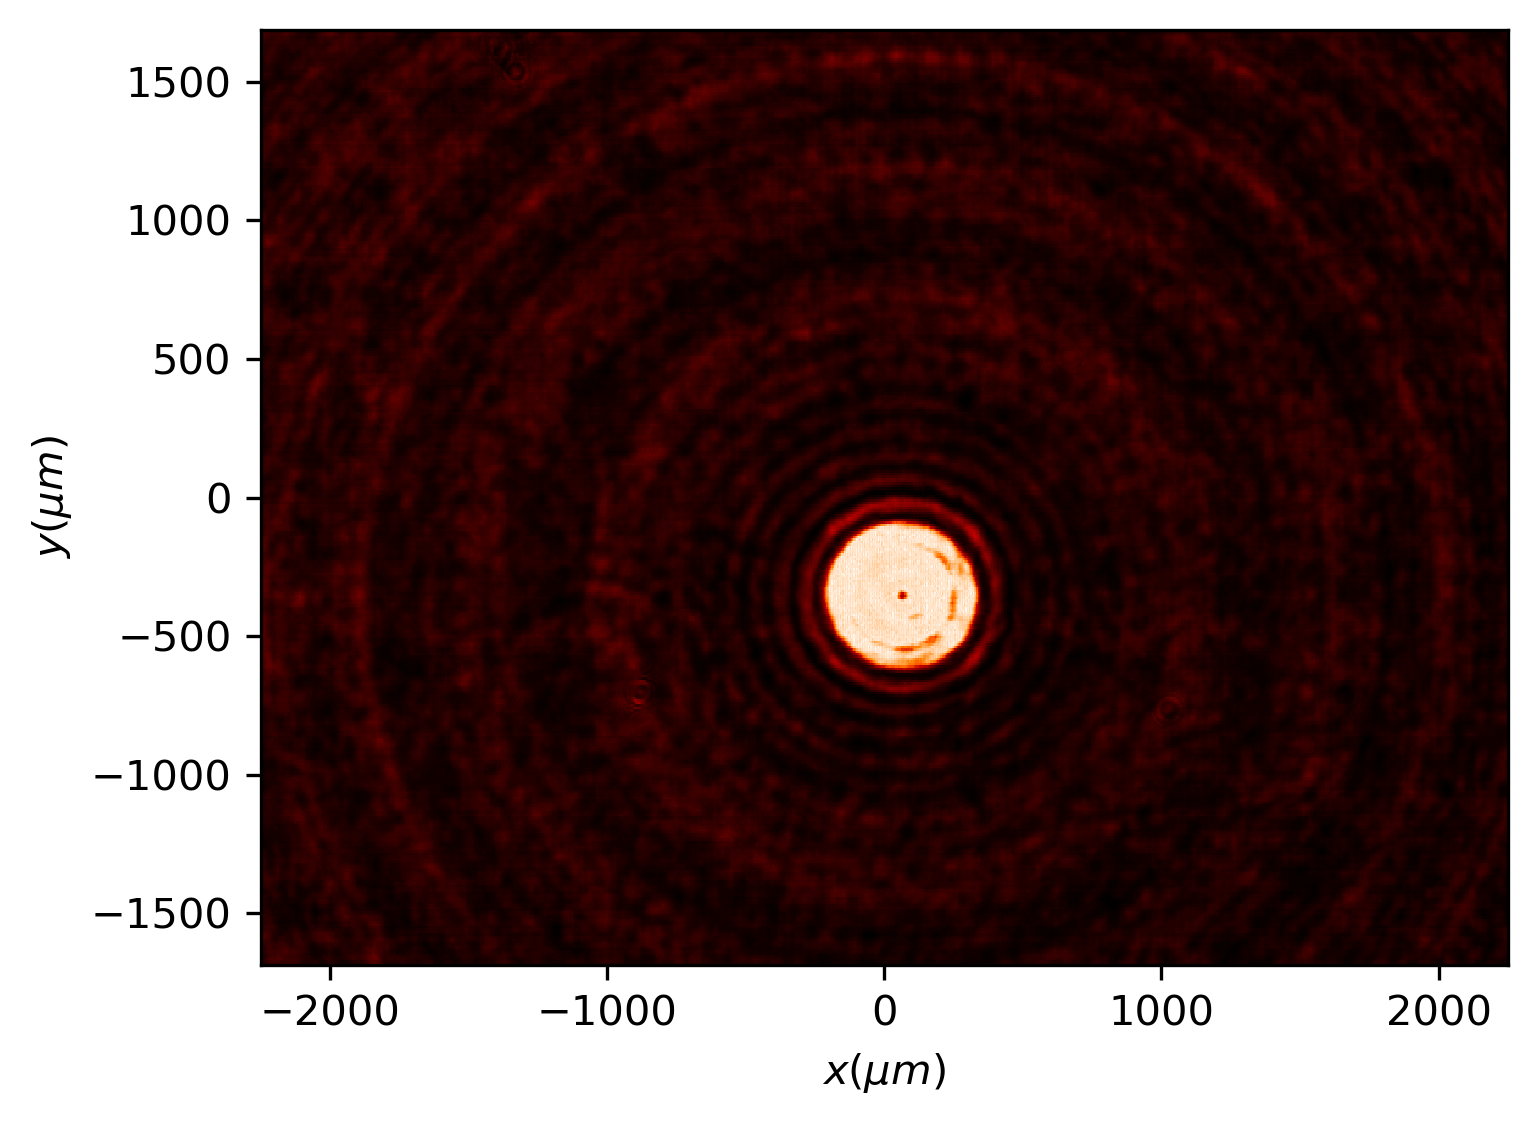

In [25]:
image.draw()

In [27]:
intensity=(np.abs(image.u)**2).max()
print(intensity)

173.0


In [29]:
base_name="calibracion_amplitud_lente"

In [31]:
intensities=np.zeros(256)

In [32]:
for i in range(256):
    gray_level=i/255
    filename="{}_{:0>3d}.npz".format(base_name,i)
    mask.fresnel_lens(r0=(0,0), radius=2*mm, focal=focal*1000, levels=(gray_level, 0), kind='intensity')
    slm.Send_Image(mask, kind='amplitude',return_array=True)
    time.sleep(0.3)
    #image = cam.Get_Image()
    #np.savez(filename, image=image-image_background)  
    image = cam.Get_Image(diffractio=True)
    intensity=(np.abs(image.u)**2).max()
    intensities[i]=intensity
    print(i, intensity,end="\r")


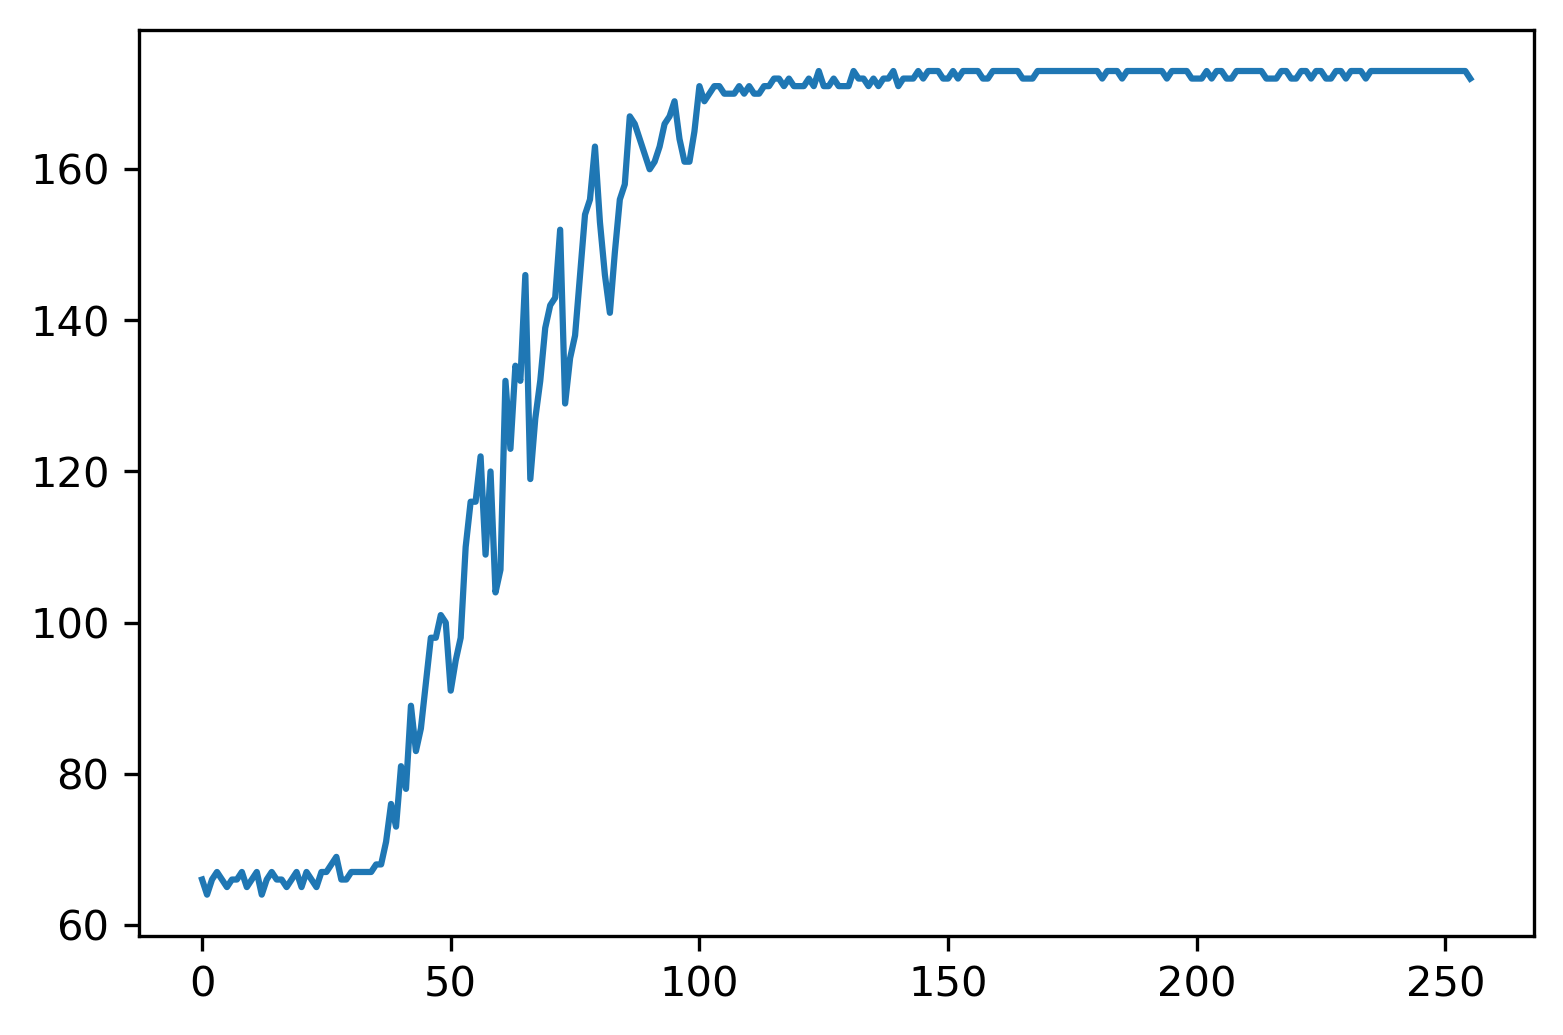

In [33]:
plt.plot(intensities)

In [91]:
cam.Stop_Live()
motor.Close()